<a href="https://colab.research.google.com/github/kylrw/Range-Estimation-MARC/blob/main/SOC_LSTM_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [4]:
from scipy.io import loadmat
from scipy.signal import find_peaks
import numpy as np
from pathlib import Path
from typing import List, Tuple
import pickle
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import numpy as np
import sys
from sklearn.metrics import mean_squared_error

Pre-Process Data

In [5]:
"""
A function to extract chunks of data from .mat files.

Args:
filenames (List[str]): A list of file paths to .mat files to extract data from.

Returns:
List[Tuple[np.ndarray, np.ndarray]]: A list of tuples, where each tuple contains two NumPy ndarrays.
The first ndarray is a chunk of data from the X variable of the .mat file,
and the second ndarray is a chunk of data from the Y variable of the .mat file.
The chunks are determined by finding peaks in the Y data and dividing the data into segments between the peaks.

Note:
This function requires the NumPy and SciPy libraries to be installed.
"""
def extract_mat_file_chunks(filenames: List[str]) -> List[Tuple[np.ndarray, np.ndarray]]:
    mat_data = [loadmat(filename) for filename in filenames]
    xs, ys = zip(*[(data["X"].T[:, :3], data["Y"].T) for data in mat_data])
    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0)

    diff = ys[1:, 0] - ys[:-1, 0]
    peaks, _ = find_peaks(diff, height=0.5) # finds peaks in y that are above 0.99, and have a distance of at least 500

    x_chunks = []
    y_chunks = []
    start = -1
    for i in peaks:
        x_chunks.append(xs[start+1:i])
        y_chunks.append(ys[start+1:i])
        start = i
    x_chunks.append(xs[start+1:])
    y_chunks.append(ys[start+1:])

    return list(zip(x_chunks, y_chunks))

In [6]:
mat_files = list(Path(".").glob("*.mat"))
mat_files.sort()
all_chunks = extract_mat_file_chunks(mat_files)
print(type(all_chunks))
#print the type of x and y in the first chunk
print(type(all_chunks[0][0]))
print(type(all_chunks[0][1]))

<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Calculate Values for Standardizing Data


In [7]:
means, stds = zip(*[(x.mean(axis=0), x.std(axis=0)) for (x, _) in all_chunks])
means = np.array(means).mean(axis=0)
stds = np.array(stds).mean(axis=0)
print(means.shape)
print(stds.shape)

(3,)
(3,)


Definine NN Architecture

In [8]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden_size = 16
        self.num_layers = 1

        # Define the LSTM layer with input size 3, output size 16, and 1 layer.
        # Set batch_first to True so that the input tensor has shape (batch_size, seq_length, input_size)
        self.lstm = nn.LSTM(3, 16, 1, batch_first=True)

        self.ln = nn.LayerNorm(16)

        # Define the fully connected layer with a dropout of 0.2 and output size of 1
        self.fc1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        # Pass the input tensor x to the LSTM layer
        out = x
        out, _ = self.lstm(out)

        # Apply layer normalization to the output of the LSTM layer
        out = self.ln(out)

        # Pass the output through the fully connected layer with dropout and clipping the output between 0 and 1
        out = self.fc1(out)
        out = torch.clip(out, 0, 1)

        return out

In [9]:
# Instantiate the LSTM model and move it to the GPU
model = LSTMModel().cuda()

# Define the mean squared error loss function
criterion = nn.MSELoss()

# Define the AdamW optimizer with a learning rate of 0.01 and optimize the model parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

Train Model

In [11]:
# Sets model to training mode
model.train()

# 200 Epochs
for i in range(100):
    loss = 0
    for (inputs, targets) in all_chunks:
        # Convert inputs and targets to tensors, normalize the inputs, and move them to the GPU
        inputs = torch.from_numpy((inputs - means) / stds).float().unsqueeze(0).cuda()
        targets = torch.from_numpy(targets).float().unsqueeze(0).cuda()

        # Forward pass through the model
        outputs = model(inputs)

        # Compute the loss and add it to the running total
        loss += criterion(outputs, targets) ** 0.5
    loss /= len(all_chunks)

    # Compute the loss and add it to the running total
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())

0.1353210210800171
0.1303011178970337
0.1262139081954956
0.12276417762041092
0.11666359007358551
0.11206058412790298
0.10925370454788208
0.10600113868713379
0.10307063907384872
0.10111618787050247
0.09859338402748108
0.09626036137342453
0.09455080330371857
0.09204105287790298
0.08972766250371933
0.08829101920127869
0.08677440881729126
0.08553765714168549
0.0839492604136467
0.08277212083339691
0.0812690332531929
0.07992155104875565
0.07863428443670273
0.07750105112791061
0.07647058367729187
0.07543571293354034
0.07400373369455338
0.07322043925523758
0.07224494963884354
0.07142851501703262
0.07061254978179932
0.06970500946044922
0.06903503090143204
0.0681830570101738
0.06732549518346786
0.06650249660015106
0.0657200962305069
0.06506717205047607
0.06464383006095886
0.0637628585100174
0.06319610029459
0.06262930482625961
0.06204039976000786
0.0615079402923584
0.06111714243888855
0.06064847111701965
0.060057222843170166
0.059571586549282074
0.059142306447029114
0.05875129997730255
0.0582639

Evaluate Model

In [12]:
# Sets model to training mode
model.eval()

# Turn off gradient tracking during inference
with torch.no_grad():
    losses = []
    for (inputs, targets) in all_chunks:
        # Convert the inputs and targets into tensors and move them to GPU
        inputs = torch.from_numpy((inputs - means) / stds).float().unsqueeze(0).cuda()
        targets = torch.from_numpy(targets).float().unsqueeze(0).cuda()

        # Forward Pass
        outputs = model(inputs)

        # Calculate the RMSE loss between the predicted outputs and the targets
        loss = criterion(outputs, targets) ** 0.5

        print(f'Loss: {loss.item():.4f}')
        losses.append(loss.item())
    print(sum(losses) / len(losses))

Loss: 0.0223
Loss: 0.0206
Loss: 0.0216
Loss: 0.0205
Loss: 0.0127
Loss: 0.0134
Loss: 0.0149
Loss: 0.0282
Loss: 0.0241
Loss: 0.0236
Loss: 0.0242
Loss: 0.0237
Loss: 0.0240
Loss: 0.0235
Loss: 0.0227
Loss: 0.0211
Loss: 0.0313
Loss: 0.0147
Loss: 0.0213
Loss: 0.0299
Loss: 0.0228
Loss: 0.0216
Loss: 0.0227
Loss: 0.0215
Loss: 0.0231
Loss: 0.0280
Loss: 0.0342
Loss: 0.0236
Loss: 0.0306
Loss: 0.0274
0.023132412942747274


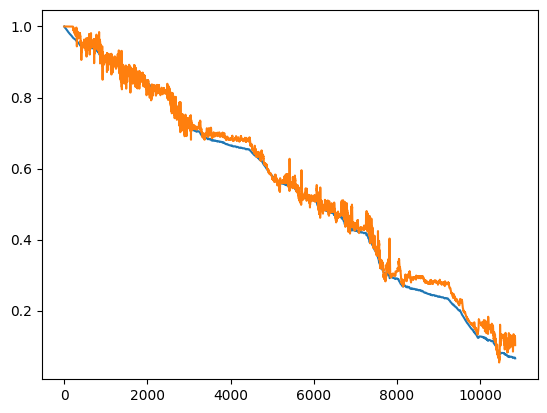

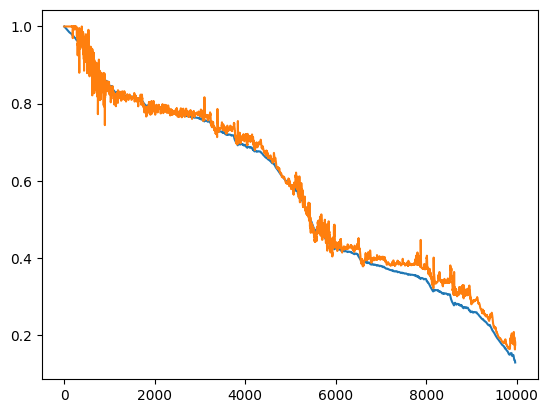

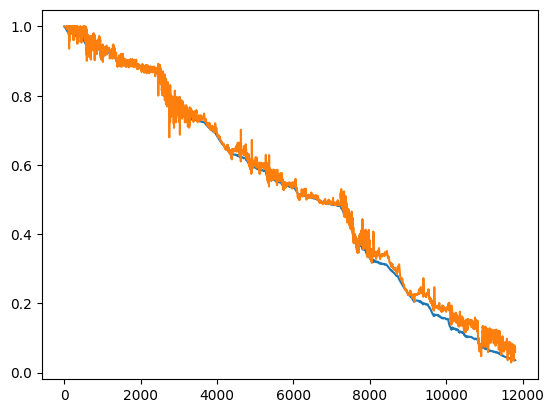

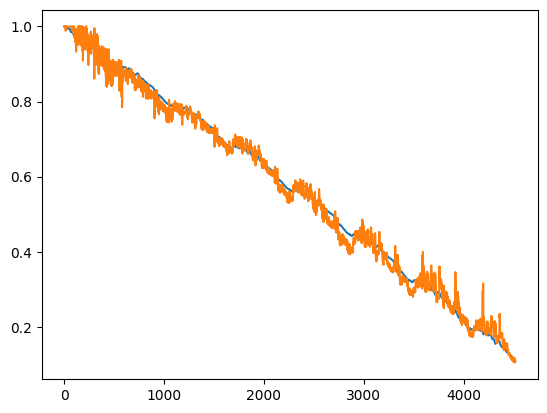

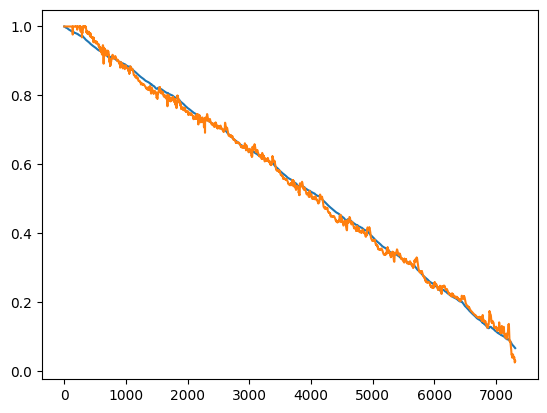

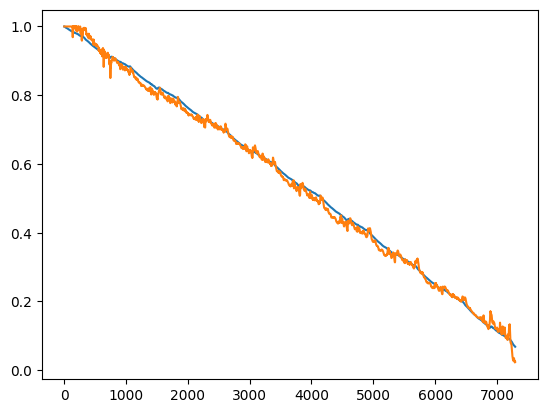

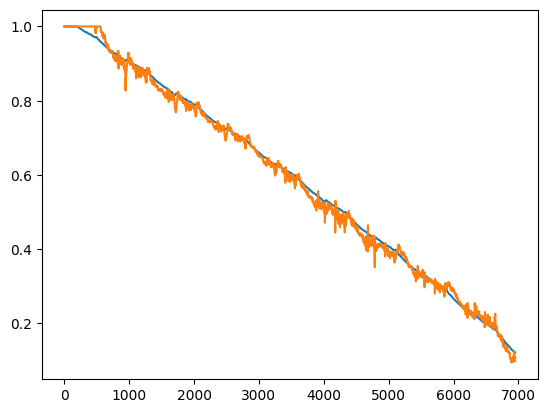

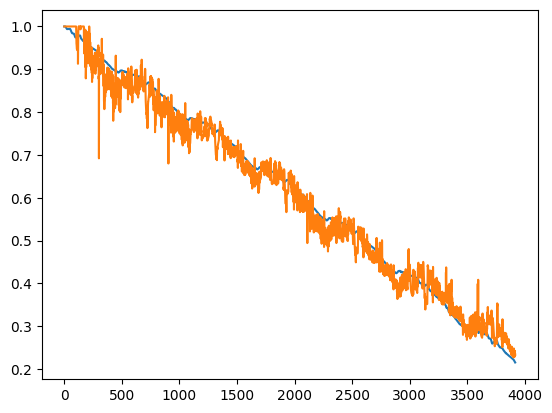

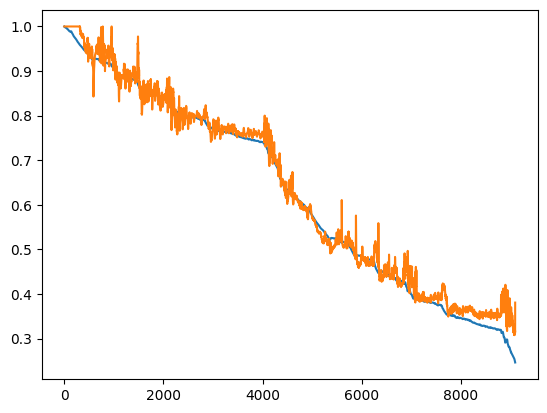

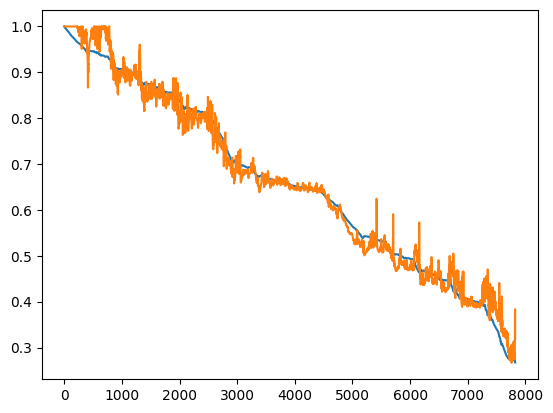

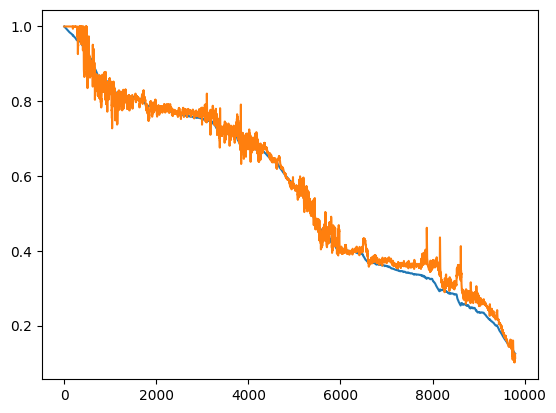

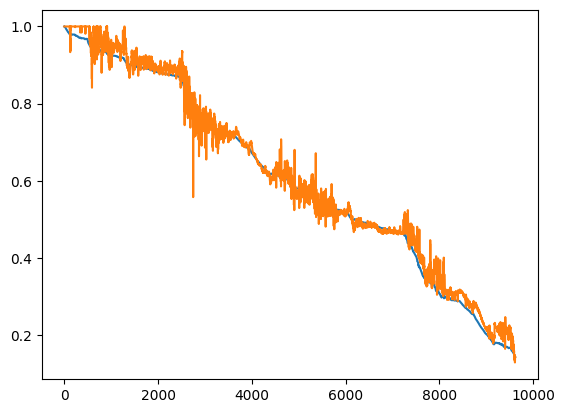

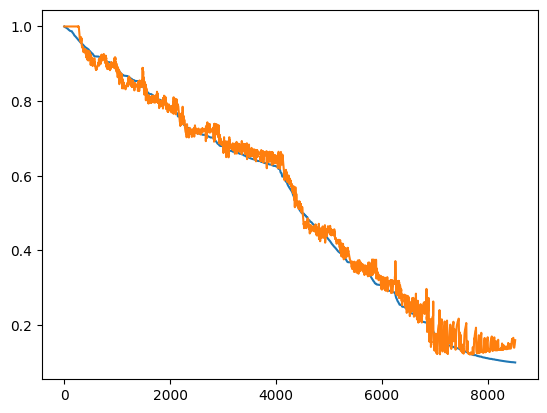

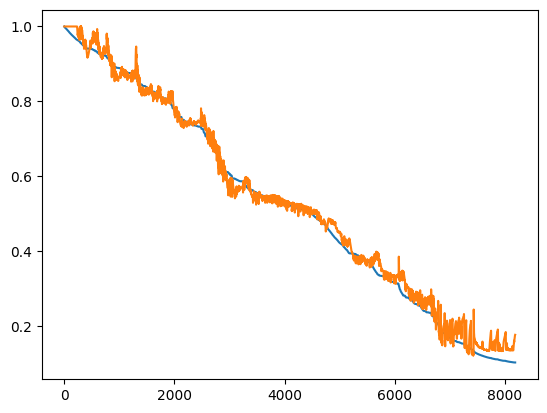

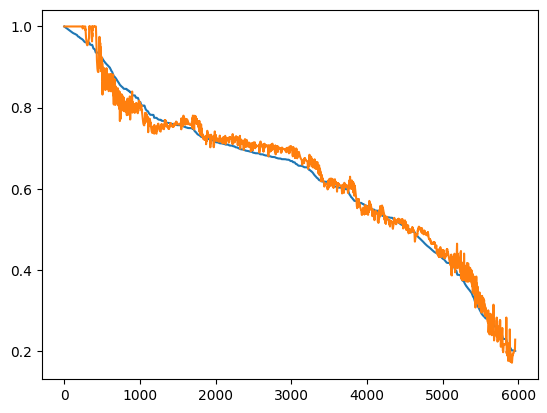

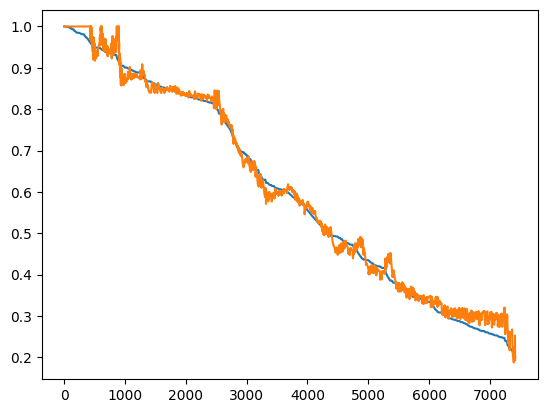

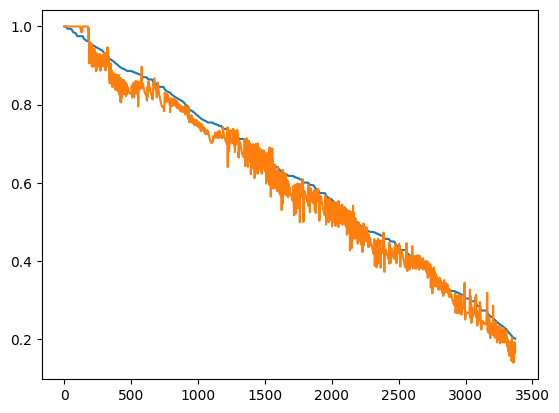

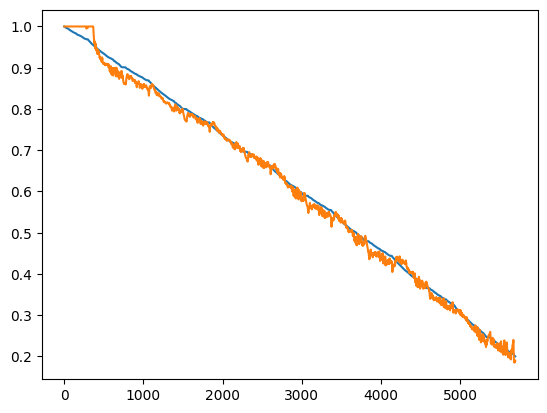

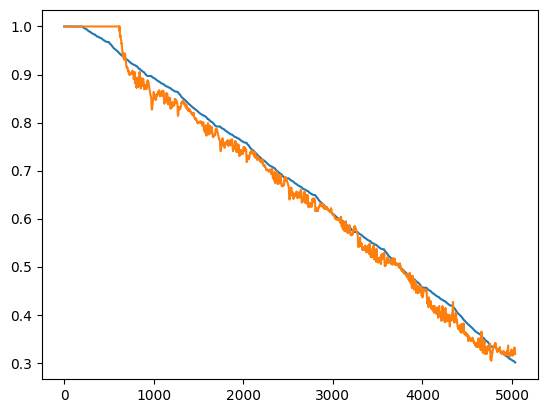

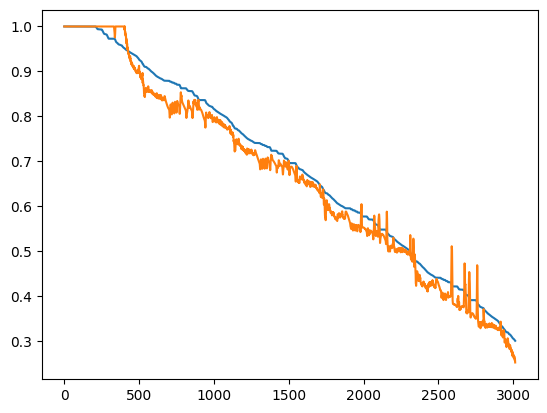

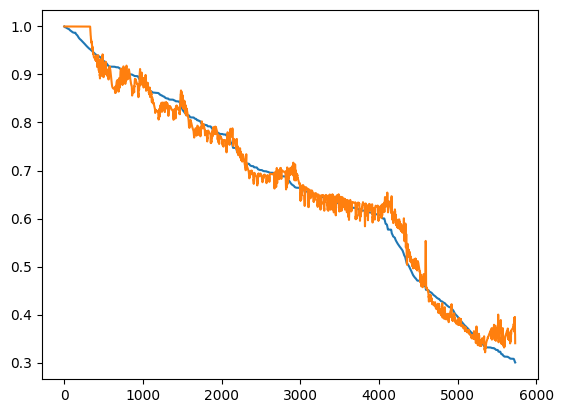

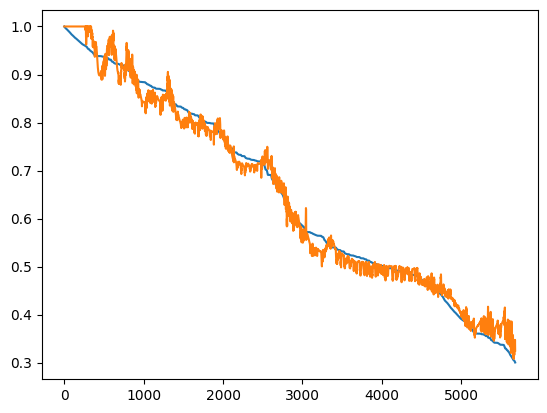

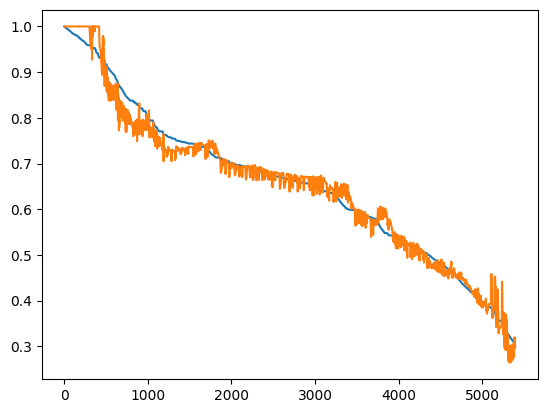

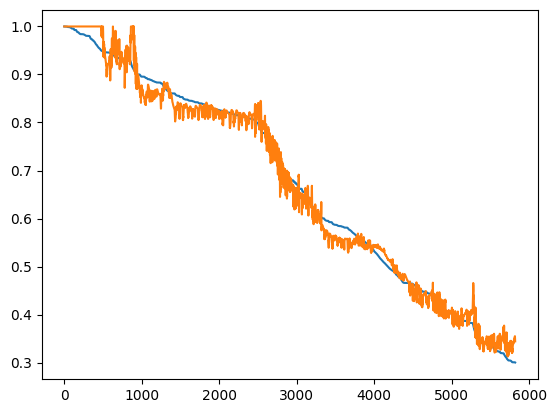

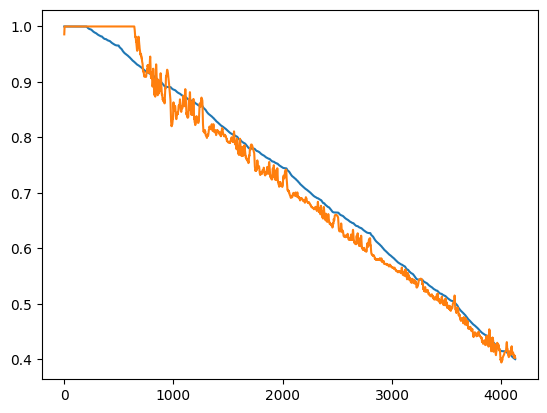

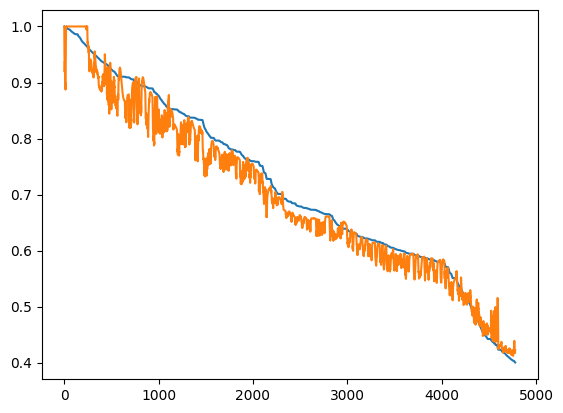

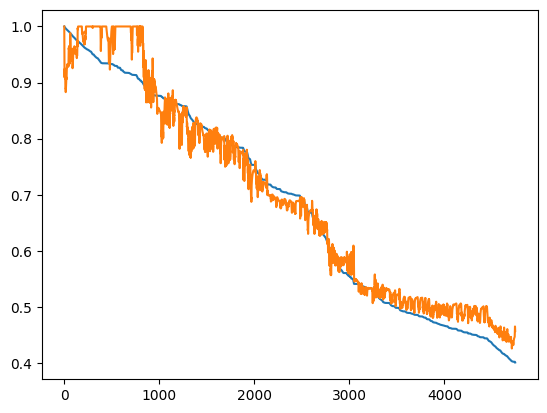

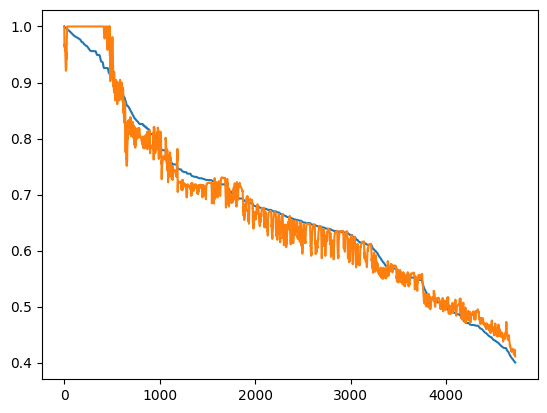

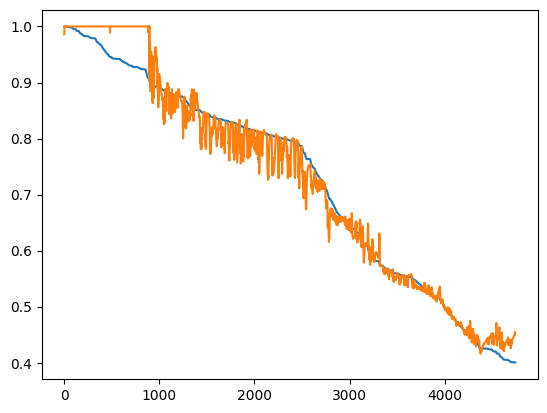

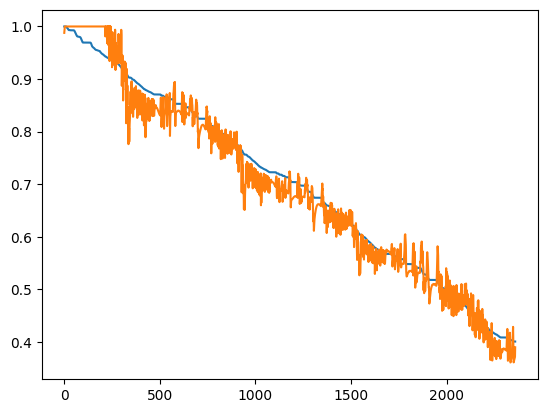

In [13]:
y = []
y_hat = []

for (inputsnp, targetsnp) in all_chunks:
    with torch.no_grad():
        inputs = torch.from_numpy((inputsnp - means) / stds).float().unsqueeze(0).cuda()
        targets = torch.from_numpy(targetsnp).float().unsqueeze(0).cuda()
        outputs = model(inputs).cpu().numpy()[0]
        plt.plot(targetsnp[:, 0])
        plt.plot(outputs[:, 0])
        y.append(targetsnp[:, 0])
        y_hat.append(outputs[:, 0])
        plt.show()


In [14]:
import math
total_rmse_test = 0
for x_idx, i in enumerate(y):
  mse_test = 0
  for y_idx, j in enumerate(i):
    mse_test += ((y_hat[x_idx][y_idx] - j)**2)
  mse_test /= i.shape[0]
  total_rmse_test += mse_test
  rmse_test = math.sqrt(mse_test)
  print("Plot", x_idx, "RMSE = ", rmse_test)
total_rmse_test /= len(y)
total_rmse_test = math.sqrt(total_rmse_test)
print("Total RMSE: ", total_rmse_test)

Plot 0 RMSE =  0.022302819365737612
Plot 1 RMSE =  0.020557479133443253
Plot 2 RMSE =  0.021582884534370184
Plot 3 RMSE =  0.020543149187896563
Plot 4 RMSE =  0.01269301751506286
Plot 5 RMSE =  0.01342155624151269
Plot 6 RMSE =  0.014920360249944102
Plot 7 RMSE =  0.028154043841080112
Plot 8 RMSE =  0.024147489913647333
Plot 9 RMSE =  0.023617359613810656
Plot 10 RMSE =  0.024248686597488876
Plot 11 RMSE =  0.02372869225395521
Plot 12 RMSE =  0.024021417055174733
Plot 13 RMSE =  0.0235247626564727
Plot 14 RMSE =  0.0226619551260229
Plot 15 RMSE =  0.021080561315046126
Plot 16 RMSE =  0.03129688703453838
Plot 17 RMSE =  0.014724826084196244
Plot 18 RMSE =  0.021252339244114234
Plot 19 RMSE =  0.029935618072761207
Plot 20 RMSE =  0.02281932223167029
Plot 21 RMSE =  0.02163818021061803
Plot 22 RMSE =  0.0227015065193004
Plot 23 RMSE =  0.02145378969274166
Plot 24 RMSE =  0.023118984410828235
Plot 25 RMSE =  0.028025152427285097
Plot 26 RMSE =  0.0342206531085762
Plot 27 RMSE =  0.02356429

Test Model

In [15]:
#val_chunks = extract_mat_file_chunks(["n10degC_LA92_Pan18650PF.mat"])

In [ ]:
#for (inputsnp, targetsnp) in val_chunks:
  #  with torch.no_grad():
   #     inputs = torch.from_numpy((inputsnp - means) / stds).float().unsqueeze(0).cuda()
   #     targets = torch.from_numpy(targetsnp).float().unsqueeze(0).cuda()
    #    outputs = model(inputs).cpu().numpy()[0]
    #    plt.plot(targetsnp[:, 0])
    #    plt.plot(outputs[:, 0])
    #    plt.show()